# Spencer Hallyburton
# AM 207 Pset 2

## Collaborator: Salvador Barragan

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi as PI
import sympy as sym
import scipy.integrate as integrate

DEC = 3

font_val = 18
plt.rc('font', size=font_val)          # controls default text sizes
plt.rc('axes', titlesize=font_val)
plt.rc('axes', labelsize=font_val)    # fontsize of the x and y labels
plt.rc('legend', fontsize=(font_val-3))    # legend fontsize
plt.rc('font', family='Sans Serif')


## Problem 1: Monte Carlo Integration

0.001
X Area: 1.00
H Area: 0.56


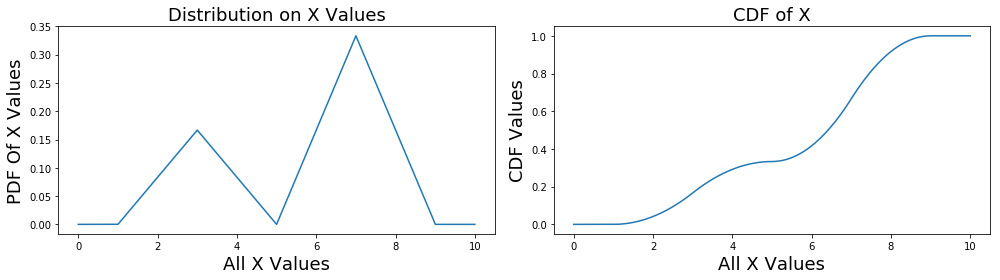

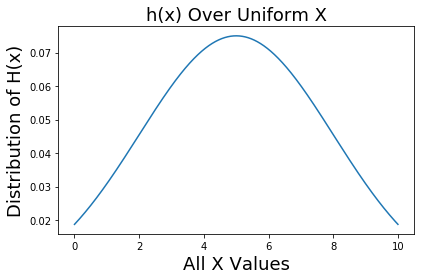

In [2]:
Nsamp = 1000
Ntrials = 100

# Describe the distribution on X:
dx = 1 * (10**-DEC)
print(dx)

x = np.arange(0, 10, dx)
x_out = np.piecewise(x, [(x>=1) * (x<=3), (x>3) * (x<=5), (x>5) * (x<=7), (x>7) * (x<=9)], 
                [lambda x: 1/12*(x-1), lambda x: -1/12*(x-5), lambda x: 1/6*(x-5), lambda x: -1/6*(x-9)])

# Define function, h(X)
h = lambda x: 1/(3*np.sqrt(2)*PI) * np.exp(-1/18 * (x-5)**2)

# Check normalization condition on both:
area_X = np.trapz(x_out, x=x)
print('X Area: %.2f' % area_X)
area_H = integrate.quad(h, -1*np.inf, np.inf)
print('H Area: %.2f' % area_H[0])

# Plotting outputs
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x, x_out)
ax[0].set_title('Distribution on X Values')
ax[0].set_xlabel('All X Values')
ax[0].set_ylabel('PDF Of X Values')
CDF_X = np.cumsum(dx*x_out)
ax[1].plot(x, CDF_X)
ax[1].set_title('CDF of X')
ax[1].set_xlabel('All X Values')
ax[1].set_ylabel('CDF Values')
plt.tight_layout()
plt.show()

# Plot h(x)
fig, ax = plt.subplots()
ax.plot(x, h(x))
ax.set_title('h(x) Over Uniform X')
ax.set_xlabel('All X Values')
ax.set_ylabel('Distribution of H(x)')
plt.tight_layout()
plt.show()



### Method 1: Inverse Transform Sampling

In [3]:
##################################################################
# Define a function for inverse sampling
def Perform_Inverse(Nsamp, x, x_out, CDF_X):
    # Sample uniformly from CDF of X
    y_rand = np.random.rand(Nsamp)
    y_rand = np.round(y_rand, decimals=DEC)
    CDF_X = np.round(CDF_X, decimals=DEC)

    # Map the y value back to X on the CDF:
    locs = []
    for yval in y_rand:
        A = np.argmax(CDF_X==yval)
        locs.append(A)

    # Get the mean value:
    h_exp_1 = np.mean(h(x[locs]))

    return(h_exp_1, locs)
##################################################################

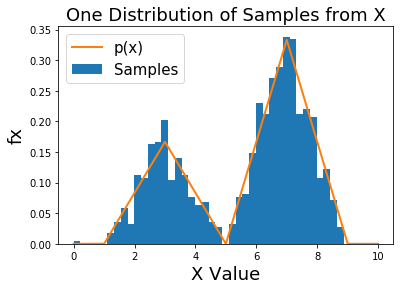

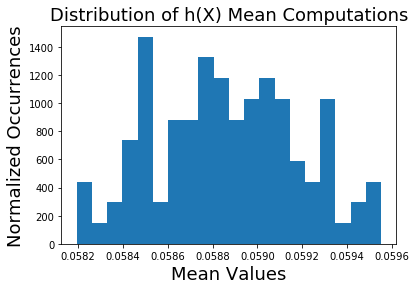

Expectation: E[h(X)] = 0.05887


In [4]:
# Evaluate the inverse sampling function
_, locs = Perform_Inverse(Nsamp, x, x_out, CDF_X)

h_out_1 = np.zeros(Ntrials)
for m in range(Ntrials):
    h_out_1[m], _ = Perform_Inverse(Nsamp, x, x_out, CDF_X)

# Plot the histogram:
plt.hist(x[locs], bins=40, normed=True,label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.title('One Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()

# Plot the histogram of mean values:
plt.hist(h_out_1, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

# Compute expectation of this:
print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_1))

### Method 2: Rejection Sampling

#### a) Uniform Proposal Distribution

In [5]:
##################################################################
# Define a function for rejection sampling
def Perform_Rejection_Uniform(Nsamp, x, x_out):
    accepted = 0
    samples = np.zeros(Nsamp)
    count = 0
    xmin = 1
    xmax = 9
    ymax = max(x_out)
    # Loop over to draw samples
    while (accepted < Nsamp):
        # Step 1: Draw uniform x from min to max
        xrand = np.round(np.random.uniform(xmin, xmax), decimals=DEC)

        # Step 2: Pick uniform on [0, ymax)
        yrand = np.random.uniform(0, ymax)

        # Step 3: Do the accept/reject comparison
        if yrand < x_out[np.where(x == xrand)]:
            samples[accepted] = xrand
            accepted += 1
        count += 1

    return(samples, count, accepted)
##################################################################

Count: 3297 Accepted: 1000


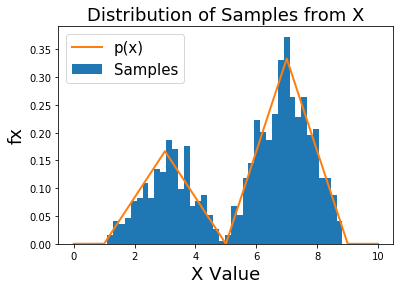

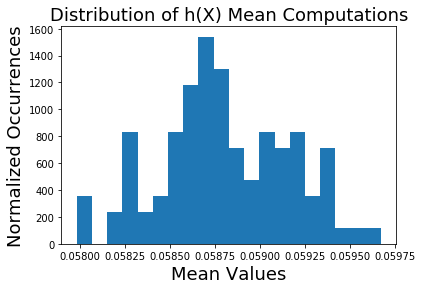

Expectation: E[h(X)] = 0.05880


In [6]:
# Evaluate the rejection sampling
samples2, count2, accepted2 = Perform_Rejection_Uniform(Nsamp, x, x_out)
print("Count:",count2, "Accepted:", accepted2)

# Plot the histogram:
plt.hist(samples2, bins=40, normed=True, label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.title('Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()


# Evaluation the Rejection Sampling many times
h_out_2 = np.zeros(Ntrials)
for m in range(Ntrials):
    samples2_all, _, _ = Perform_Rejection_Uniform(Nsamp, x, x_out)
    h_out_2[m] = np.mean(h(samples2_all))
    
# Plot the histogram of mean values:
plt.hist(h_out_2, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_2))

#### b) Normal Proposal Distribution (Steroids)

In [7]:
# Create a proposal pdf: Normal Distribution
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*PI)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

Mg = lambda x: 2.8*gaussian(x, 6, 3)
invCDFg = lambda x: dx*np.sum(Mg(np.arange(1-dx, x, dx))) # generates our proposal using inverse sampling
CDFvals = np.round( list(map(lambda val: invCDFg(val), x)), decimals= DEC)

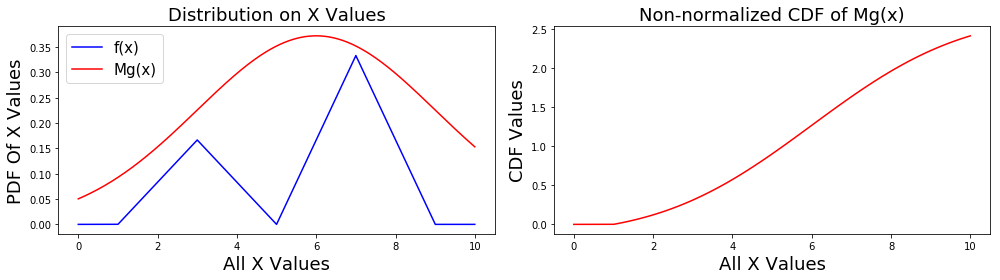

Inverse Sampling Range: (0.00019, 2.22198)


In [8]:
# domain limits
xmin = 1 # the lower limit of our domain
xmax = 9 # the upper limit of our domain

# Show proposal overlayed on Normal distribution
# Plotting outputs
fig, ax = plt.subplots(1,2,figsize=(14,4))
ax[0].plot(x, x_out,'b', label=u'f(x)')
ax[0].plot(x, Mg(x),'r', label=u'Mg(x)')
ax[0].set_title('Distribution on X Values')
ax[0].set_xlabel('All X Values')
ax[0].set_ylabel('PDF Of X Values')
ax[0].legend()
ax[1].plot(x, CDFvals, 'r')
ax[1].set_title('Non-normalized CDF of Mg(x)')
ax[1].set_xlabel('All X Values')
ax[1].set_ylabel('CDF Values')
plt.tight_layout()
plt.show()

# range limits for inverse sampling
umin = invCDFg(xmin)
umax = invCDFg(xmax)
print('Inverse Sampling Range: (%.5f, %.5f)' % (umin, umax))


In [58]:
##################################################################
# Define a function for rejection sampling on steroids
def Perform_Rejection_Steroids(Nsamp, x, x_out, umin, umax, Mg, CDFvals):
    accepted = 0
    samples = np.zeros(Nsamp)
    count = 0
    
    # Generation Loop
    while (accepted < Nsamp):
        # Sample from M*g using inverse sampling
        u = np.round( np.random.uniform(umin, umax), decimals=DEC)
        
        # Map the u value back to X on the CDF:
        xproposal = x[np.argmax(CDFvals==u)]
        
        # Pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        p = x_out[np.argmax(x==xproposal)]
        if y < p / Mg(xproposal):
            samples[accepted] = xproposal
            accepted+=1
        count += 1

    return(samples, count, accepted)
##################################################################

Count: 2217 Accepted: 1000


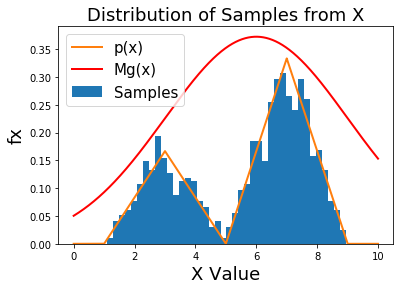

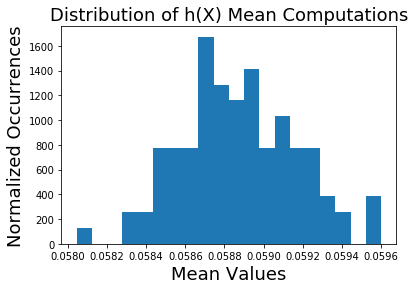

Expectation: E[h(X)] = 0.05887


In [10]:
# Evaluate the rejection sampling on steroids
samples3, count3, accepted3 = Perform_Rejection_Steroids(Nsamp, x, x_out, umin, umax, Mg, CDFvals)
print("Count:",count3, "Accepted:", accepted3)

# Plot the histogram:
plt.hist(samples3, bins=40, normed=True, label=u'Samples')
plt.plot(x, x_out, linewidth=2, label=u'p(x)')
plt.plot(x, Mg(x), 'r', linewidth=2, label=u'Mg(x)')
plt.title('Distribution of Samples from X')
plt.xlabel('X Value')
plt.ylabel('fx')
plt.legend()
plt.show()


# Evaluation the Rejection Sampling many times
h_out_3 = np.zeros(Ntrials)
for m in range(Ntrials):
    samples3_all, _, _ = Perform_Rejection_Steroids(Nsamp, x, x_out, umin, umax, Mg, CDFvals)
    h_out_3[m] = np.mean(h(samples3_all))
    
# Plot the histogram of mean values:
plt.hist(h_out_3, bins=20, normed=True)
plt.title('Distribution of h(X) Mean Computations')
plt.ylabel('Normalized Occurrences')
plt.xlabel('Mean Values')
plt.show()

# Compute expectation:
print('Expectation: E[h(X)] = %.5f' % np.mean(h_out_3))

## Problem 2: Variance Reduction

### Part a) Variance Assessment

In [11]:
# Computing Variance of each estimate of expectation:
print('Variance for each method\n\nInverse: %.4e\nRejection 1: %.4e\nRejection 2: %.4e'
      % (np.var(h_out_1), np.var(h_out_2), np.var(h_out_3)))

Variance for each method

Inverse: 1.0332e-07
Rejection 1: 1.3007e-07
Rejection 2: 8.5682e-08


After computing the variances for each of the methods, we see that they are all reasonbly close together. We can then posit that each of these methods is equivalent in terms of the variance in their prediction.

### Part b) Stratified Sampling

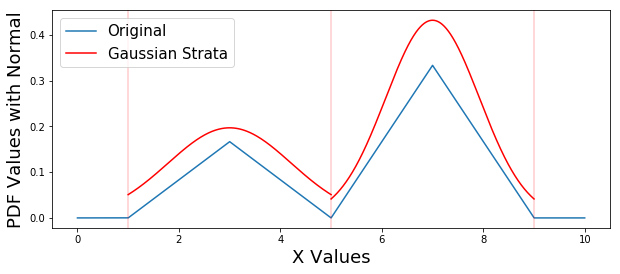

In [59]:
# Step 1: Find a natural way to divide the domain of X - divide into 2 strata
Ns = 2 # Number of strata
Ntry = 100 # Number of tries in each region
np.random.seed(seed=1)

xmin = 1
xmax = 9
step = (xmax - xmin)/Ns
sigmas = np.zeros(Ns)

Utry = np.round(np.random.uniform(low=xmin, high=xmax, size=Ntry), decimals=DEC)
locs = []
for yval in Utry:
    A = np.argmax(x==yval)
    locs.append(A)
Ytry = x[locs]
Umin = 0
Umax = step

# Calculate standard deviation of points in each region
for reg in np.arange(0,Ns):
    localmask = (Utry >= Umin) & (Utry < Umax)
    sigmas[reg] = np.std(Ytry[localmask])
    Umin = Umin + step
    Umax = Umax + step
    
# Determine parameters for normal proposals and show on plot:
Mg1 = lambda x: 3/5*gaussian(x, 3, sigmas[0])
x1 = x[(x>=xmin) & (x<=(xmin+step))]
Mg2 = lambda x: 1*gaussian(x, 7, sigmas[1]/2)
x2 = x[(x>=(step+xmin)) & (x<=xmax)]

invCDFg1 = lambda x: dx*np.sum(Mg1(np.arange(1-dx, x, dx))) # generates our proposal using inverse sampling
CDFvals1 = np.round( list(map(lambda val: invCDFg1(val), x1)), decimals= DEC)

invCDFg2 = lambda x: dx*np.sum(Mg2(np.arange(5-dx, x, dx))) # generates our proposal using inverse sampling
CDFvals2 = np.round( list(map(lambda val: invCDFg2(val), x2)), decimals= DEC)

fig = plt.figure(figsize=(10,4))
plt.plot(x, x_out, label='Original')
for j in range(Ns+1):
    plt.axvline(xmin + j*step, 0, 1, color='r', alpha=0.2)
plt.plot(x1, Mg1(x1), color='r', label=u'Gaussian Strata')
plt.plot(x2, Mg2(x2), color='r')
plt.xlabel('X Values')
plt.ylabel('PDF Values with Normal')
plt.legend()
plt.show()

In [134]:
# Calculate number of points for sampling in each region
Ntrials = 100
Nsamp = 200
nums = np.ceil(Nsamp*sigmas/np.sum(sigmas)).astype(int)

Is = np.zeros(Ntrials)

# Loop over each trial
for k in np.arange(0, Ntrials):
    # Start in the first region with everything set to zero
    Umin = xmin
    Umax = step+xmin
    Ii = 0
    
    # Loop over each region
    for reg in np.arange(0, Ns):
        # Sample using rejection sampling:
        if reg==0:
            Mg = lambda x: Mg1(x)
            CDF = CDFvals1
            umin_in = invCDFg1(Umin)
            umax_in = invCDFg1(Umax)
        elif reg==1:
            Mg = lambda x: Mg2(x)
            CDF = CDFvals2
            umin_in = invCDFg2(Umin)
            umax_in = invCDFg2(Umax)
        
        # Rejection sampling using number of points as proportional to size of region
        samples, count, accepted = Perform_Rejection_Steroids(nums[reg], x, x_out, umin_in, umax_in, Mg, CDF)

        #Add points in weighted fashion
        Ii = Ii + nums[reg]/sum(nums)*np.mean(h(samples))

        # Update the region
        Umin = Umin + step
        Umax = Umax + step

    # Add integral value
    Is[k] = Ii


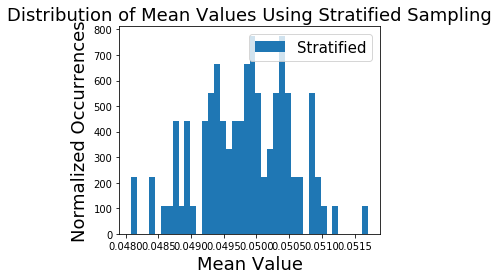

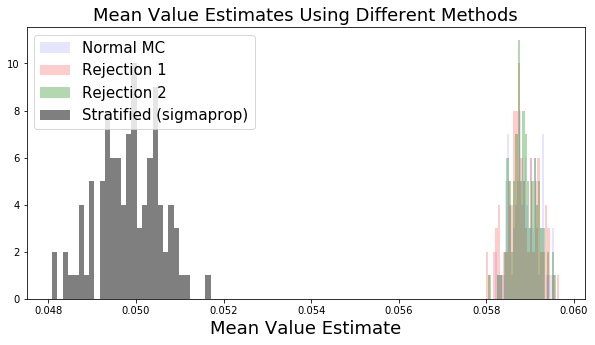

Mean Value Calculation: 0.0498
Variance Using Stratified: 0.0000


In [136]:
# Plot stratified sampling method
plt.hist(Is, bins=40, histtype='stepfilled', label=u'Stratified', normed=True)
plt.legend()
plt.title('Distribution of Mean Values Using Stratified Sampling')
plt.xlabel('Mean Value')
plt.ylabel('Normalized Occurrences')
plt.tight_layout()
plt.show()

# Plot all three methods at once:
plt.figure(figsize=(10,5))
plt.hist(h_out_1,30, histtype='stepfilled', color='b', label=u'Normal MC', alpha=0.1)
plt.hist(h_out_2,30, histtype='stepfilled', color='r', label=u'Rejection 1', alpha=0.2)
plt.hist(h_out_3, 30, histtype='stepfilled',color='g', label=u'Rejection 2', alpha=0.3)
plt.hist(Is, 30, histtype='stepfilled',color='k', label=u'Stratified (sigmaprop)', alpha=0.5)
plt.xlabel('Mean Value Estimate')
plt.title('Mean Value Estimates Using Different Methods')
plt.legend()
plt.show()

print('Mean Value Calculation: %.4f' % np.mean(Is))
print('Variance Using Stratified: %.4f' % np.var(Is))


## Problem 3: Linear Regression¶


### Part a) Create Linear Regression Class

In [138]:
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params[k]
    
    def set_params(self, **kwargs):
        for k,v in kwargs.iteritems():
            self.params[k] = v
        
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()

        
class OLS(Regression):

